<a href="https://colab.research.google.com/github/charlesbloomer/DNSC6301-Group-23/blob/main/DNSC6301_Group_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python Imports:

In [1]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

import io
from google.colab import files

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt 
import seaborn as sns

SEED = 567890

print ("Done with imports")

Done with imports


Upload training data

In [2]:
from google.colab import files 
uploaded = files.upload()

Saving credit_line_increase (1).csv to credit_line_increase (1).csv


In [3]:
type(uploaded)

dict

In [4]:
uploaded.keys()

dict_keys(['credit_line_increase (1).csv'])

In [5]:
data = pd.read_csv(io.StringIO(uploaded['credit_line_increase (1).csv'].decode('utf-8')))

1. Load and Analyze Data

In [6]:
data.columns # Determine the names of the columns in the training data.

Index(['ID', 'LIMIT_BAL', 'SEX', 'RACE', 'EDUCATION', 'MARRIAGE', 'AGE',
       'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
       'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
       'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'DELINQ_NEXT'],
      dtype='object')

In [7]:
data.isnull().any() # Determine whether any missing values exist in the training data.

ID             False
LIMIT_BAL      False
SEX            False
RACE           False
EDUCATION      False
MARRIAGE       False
AGE            False
PAY_0          False
PAY_2          False
PAY_3          False
PAY_4          False
PAY_5          False
PAY_6          False
BILL_AMT1      False
BILL_AMT2      False
BILL_AMT3      False
BILL_AMT4      False
BILL_AMT5      False
BILL_AMT6      False
PAY_AMT1       False
PAY_AMT2       False
PAY_AMT3       False
PAY_AMT4       False
PAY_AMT5       False
PAY_AMT6       False
DELINQ_NEXT    False
dtype: bool

In [8]:
data.describe() # Calculate basic descriptive statistics for the data.

,ID,LIMIT_BAL,SEX,RACE,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DELINQ_NEXT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,2.721967,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,1.094397,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,2.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,3.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,4.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,4.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [9]:
corr = data.corr # Calculate a Pearson correlation matrix for the data.
corr

<bound method DataFrame.corr of           ID  LIMIT_BAL  SEX  RACE  ...  PAY_AMT4  PAY_AMT5  PAY_AMT6  DELINQ_NEXT
0          1      20000    2   1.0  ...         0         0         0            1
1          2     120000    2   2.0  ...      1000         0      2000            1
2          3      90000    2   3.0  ...      1000      1000      5000            0
3          4      50000    2   4.0  ...      1100      1069      1000            0
4          5      50000    1   3.0  ...      9000       689       679            0
...      ...        ...  ...   ...  ...       ...       ...       ...          ...
29995  29996     220000    1   4.0  ...      3047      5000      1000            0
29996  29997     150000    1   4.0  ...       129         0         0            0
29997  29998      30000    1   1.0  ...      4200      2000      3100            1
29998  29999      80000    1   2.0  ...      1926     52964      1804            1
29999  30000      50000    1   2.0  ...      1000      

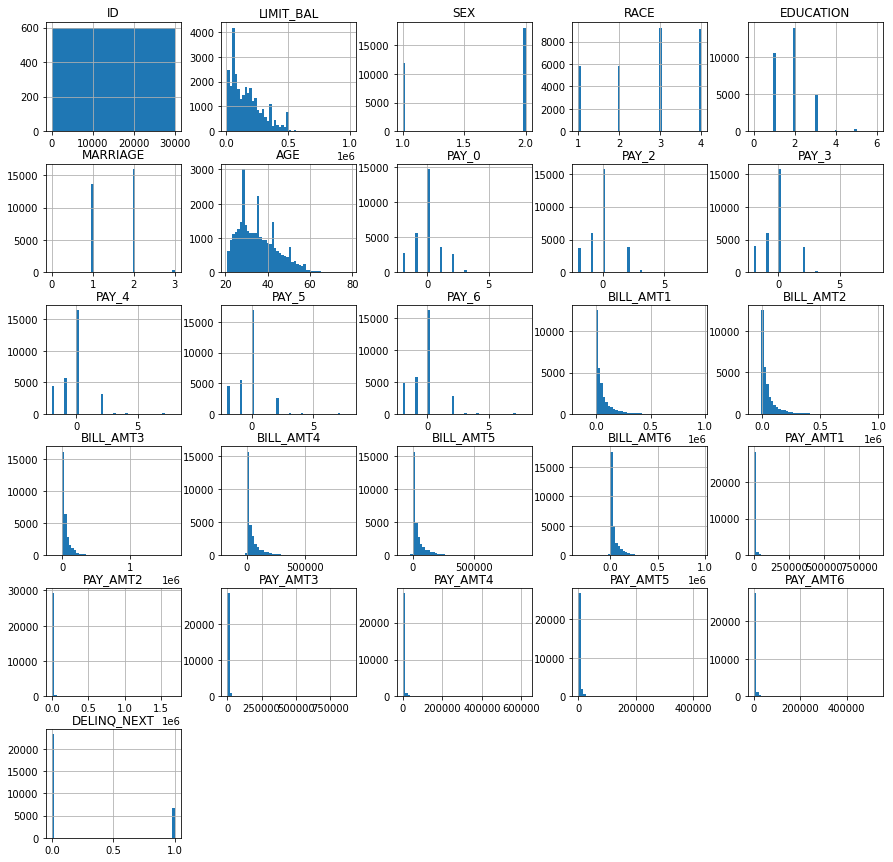

In [10]:
_ = data[data.columns].hist(bins=50, figsize=(15, 15)) # Plot histograms for all the columns in the data 

2. Train a decision tree model.

In [11]:
y_name = 'DELINQ_NEXT'
X_names = ['LIMIT_BAL', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

In [12]:
# Partition the data into training, validation, and test sets
train_X, valid_test_X, train_y, valid_test_y = train_test_split(data[X_names], data[y_name], test_size=0.5, random_state=SEED) # split off training data
valid_X, test_X, valid_y, test_y = train_test_split(valid_test_X, valid_test_y, test_size=0.5, random_state=SEED) # split remainder into validation and test

# Summarize
print('Training data: %i rows and %i columns' % (train_X.shape[0], train_X.shape[1] + 1))
print('Validation data: %i rows and %i columns' % (valid_X.shape[0], valid_X.shape[1] + 1))
print('Testing data: %i rows and %i columns' % (test_X.shape[0], test_X.shape[1] + 1))

# Housekeeping
del valid_test_X 
del valid_test_y

Training data: 15000 rows and 20 columns
Validation data: 7500 rows and 20 columns
Testing data: 7500 rows and 20 columns


In [13]:
# Train decision tree with validation-based early stopping
max_depth = 12
candidate_models = {}

# cycle through tree depths to find best model
for depth in range(0, max_depth):

  # fit a model at max_depth = depth+1
  clf = tree.DecisionTreeClassifier(max_depth = depth + 1, random_state=SEED)
  clf.fit(train_X, train_y)

  # score training and validation data
  train_phat = clf.predict_proba(train_X)[:, 1]
  valid_phat = clf.predict_proba(valid_X)[:, 1]

  # calculate AUC to assess performance quality
  train_auc = roc_auc_score(train_y, train_phat)
  valid_auc = roc_auc_score(valid_y, valid_phat)

  # calculate cross validation scores to assess stability
  cv_scores = cross_val_score(clf, valid_X, valid_y, scoring='roc_auc', cv=5)
  cv_std = np.std(cv_scores)

  # store results to analyze and select best model
  candidate_models[depth + 1] = {}
  candidate_models[depth + 1]['Model'] = clf
  candidate_models[depth + 1]['Training AUC'] = train_auc
  candidate_models[depth + 1]['Validation AUC'] = valid_auc
  candidate_models[depth + 1]['5-Fold SD'] = cv_std

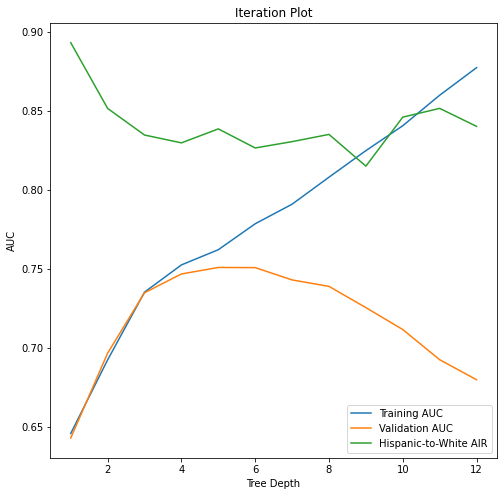

In [36]:
# Plot tree depth vs. training and validation AUC using simple pandas plotting and matplotlib
candidate_results = pd.DataFrame.from_dict(candidate_models, orient='index')
fig, ax = plt.subplots(figsize=(8, 8))
_ = candidate_results[['Training AUC', 'Validation AUC', 'Hispanic-to-White AIR']].plot(title='Iteration Plot',ax=ax)
_ = ax.set_xlabel('Tree Depth')
_ = ax.set_ylabel('AUC')

In [15]:
 # View same results as a table, using pandas iloc to remove first column of table
candidate_results.iloc[:, 1:]

,Training AUC,Validation AUC,5-Fold SD
1,0.645587,0.642702,0.014669
2,0.692215,0.696462,0.012178
3,0.735124,0.734738,0.017265
4,0.752370,0.746636,0.011874
5,0.761992,0.750750,0.014535
6,0.778430,0.750651,0.014617
7,0.790834,0.742856,0.020927
8,0.807937,0.738774,0.025695
9,0.824754,0.725309,0.027958
10,0.840533,0.711415,0.024084


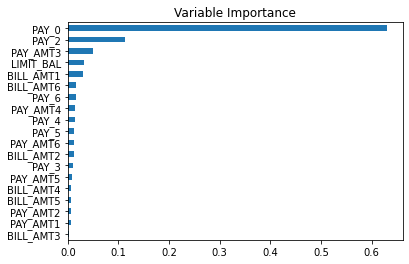

In [21]:
# plot variable importances
# create pandas dataframe
# plot dataframe values
best_model = candidate_models[6]['Model']
fig = plt.figure(figsize=(400, 70))
_ = tree.plot_tree(best_model,
                   feature_names=X_names,
                   class_names=['On time', 'Delinquent'],
                   filled=True)

importances = pd.DataFrame(best_model.feature_importances_,
                           index=X_names,
                           columns=['Importance'])
_ = importances.sort_values(by='Importance').plot(kind='barh', title='Variable Importance', legend=False)

In [22]:
# score on test data for 
# final HONEST assessment
# this is not to see how well the model *did*!
# it's to get an assessment of how it *will do* on unseen data!
test_phat = best_model.predict_proba(test_X)[:,1]
print('Test AUC: %.4f' % roc_auc_score(test_y, test_phat))

Test AUC: 0.7448


3. Test for discrimination

In [18]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    frame_ = frame.copy(deep=True)

    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)

    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]

    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))

    return cm_frame

# Calculate adverse impact ratios (AIR) for each applicable race (Black, Hispanic, Asian) and sex (Female) group in validation data. 
def air(cm_dict, reference_key, protected_key, verbose=True):

    eps = 1e-20

    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1])
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)

    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) 
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    return ((protected_prop + eps)/(reference_prop + eps))

In [23]:
# adding probabilities onto validation set
valid_yhat = pd.DataFrame(valid_X, columns=X_names)
valid_yhat['RACE'] = data.loc[valid_yhat.index, 'RACE']
valid_yhat['SEX'] = data.loc[valid_yhat.index, 'SEX']
valid_yhat[y_name]  = valid_y
valid_yhat['phat'] = best_model.predict_proba(valid_X)[:, 1]
valid_yhat.head()

# Calculate confusion matrices across race groups
race_dict = {'hispanic': 1,
             'black': 2,
             'white': 3,
             'asian': 4}

race_group_names = list(race_dict.keys())
race_cm_dict = {}

# Calculate confusion matrices at standard cutoff 0.15
for name in race_group_names:
    race_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=race_dict[name], cutoff=0.15)
    print(race_cm_dict[name])
    print('(%s)' % name.title())
    print()

# Calculate AIR
for name in race_group_names:
   if name != 'white':
      print('%s-to-%s AIR: %.2f' % (name, 'white', air(race_cm_dict, 'white', name)))
      print()

# Calculate confusion matrices across sex groups
sex_dict = {'male': 1,
            'female': 2}

sex_group_names = list(sex_dict.keys())
sex_cm_dict = {}

# Calculate confusion matrices at standard cutoff 0.15
for name in sex_group_names:
    sex_cm_dict[name] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='SEX', level=sex_dict[name], cutoff=0.15)
    print(sex_cm_dict[name])
    print('(%s)' % name.title())
    print()

# Calculate AIR
for name in sex_group_names:
   if name != 'male':
      print('%s-to-%s AIR: %.2f' % (name, 'male', air(sex_cm_dict, 'male', name)))
      print()

Confusion matrix by RACE=1
             actual: 1 actual: 0
predicted: 1       432       266
predicted: 0       166       577
(Hispanic)

Confusion matrix by RACE=2
             actual: 1 actual: 0
predicted: 1       405       308
predicted: 0       195       580
(Black)

Confusion matrix by RACE=3
             actual: 1 actual: 0
predicted: 1       176       671
predicted: 0        68      1337
(White)

Confusion matrix by RACE=4
             actual: 1 actual: 0
predicted: 1       170       655
predicted: 0        73      1421
(Asian)

White proportion accepted: 0.624
Hispanic proportion accepted: 0.516
hispanic-to-white AIR: 0.83

White proportion accepted: 0.624
Black proportion accepted: 0.521
black-to-white AIR: 0.83

White proportion accepted: 0.624
Asian proportion accepted: 0.644
asian-to-white AIR: 1.03

Confusion matrix by SEX=1
             actual: 1 actual: 0
predicted: 1       529       758
predicted: 0       199      1424
(Male)

Confusion matrix by SEX=2
             act

4. Remediate discovered discrimination

In [34]:
# Use techniques we discussed in class (changing cutoff, model selection, in-, pre-, and post-processing) to remediate any discovered bias. This means AIR should be above 0.8 for all protected classes, and AIR should not decrease below 0.8 for any group that was originally not experiencing bias. AIR measurements should be made in validation data.
  # function to get accuracy at probability cutoff
def get_acc(frame, cutoff, y_name, yhat_name):

  temp = frame.copy(deep=True) 
  temp['decision'] = np.where(temp[yhat_name] > cutoff , 1, 0)
  acc = accuracy_score(temp[y_name], temp['decision'])
  del temp
  return acc

In [42]:
# accuracy as cutoff increases
from sklearn.metrics import accuracy_score

for cutoff in np.arange(0.1, 0.31, 0.01):
  print('Accuracy at cutoff %.2f is: %.4f' % (np.round(cutoff, 2),get_acc(valid_yhat, np.round(cutoff, 2), y_name, 'phat')))

Accuracy at cutoff 0.10 is: 0.5417
Accuracy at cutoff 0.11 is: 0.5903
Accuracy at cutoff 0.12 is: 0.5980
Accuracy at cutoff 0.13 is: 0.6693
Accuracy at cutoff 0.14 is: 0.6788
Accuracy at cutoff 0.15 is: 0.6788
Accuracy at cutoff 0.16 is: 0.6945
Accuracy at cutoff 0.17 is: 0.7112
Accuracy at cutoff 0.18 is: 0.7183
Accuracy at cutoff 0.19 is: 0.7336
Accuracy at cutoff 0.20 is: 0.7359
Accuracy at cutoff 0.21 is: 0.7409
Accuracy at cutoff 0.22 is: 0.7409
Accuracy at cutoff 0.23 is: 0.7553
Accuracy at cutoff 0.24 is: 0.7553
Accuracy at cutoff 0.25 is: 0.7557
Accuracy at cutoff 0.26 is: 0.7613
Accuracy at cutoff 0.27 is: 0.7613
Accuracy at cutoff 0.28 is: 0.7623
Accuracy at cutoff 0.29 is: 0.7869
Accuracy at cutoff 0.30 is: 0.7899


In [29]:
# Display the new test error.      
max_depth = 12
candidate_models = {}

for depth in range(0, max_depth):

  clf = tree.DecisionTreeClassifier(max_depth = depth + 1, random_state=SEED)
  clf.fit(train_X, train_y)

  train_phat = clf.predict_proba(train_X)[:, 1]
  valid_phat = clf.predict_proba(valid_X)[:, 1]

  train_auc = roc_auc_score(train_y, train_phat)
  valid_auc = roc_auc_score(valid_y, valid_phat)

  valid_yhat = pd.DataFrame(valid_X, columns=X_names)
  valid_yhat['RACE'] = data.loc[valid_yhat.index, 'RACE']
  valid_yhat[y_name] = valid_y
  valid_yhat['phat'] = valid_phat
  cm_dict = {}
  cm_dict['white'] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=3, cutoff=0.18, verbose=False)
  cm_dict['hispanic'] = get_confusion_matrix(valid_yhat, y_name, 'phat', by='RACE', level=1, cutoff=0.18, verbose=False)
  valid_hispanic_air = air(cm_dict, 'white', 'hispanic', verbose=False)

  cv_scores = cross_val_score(clf, valid_X, valid_y, scoring='roc_auc', cv=5)
  cv_std = np.std(cv_scores)

  candidate_models[depth + 1] = {}
  candidate_models[depth + 1]['Model'] = clf
  candidate_models[depth + 1]['Training AUC'] = train_auc
  candidate_models[depth + 1]['Validation AUC'] = valid_auc
  candidate_models[depth + 1]['5-Fold SD'] = cv_std
  candidate_models[depth + 1]['Hispanic-to-White AIR'] = valid_hispanic_air

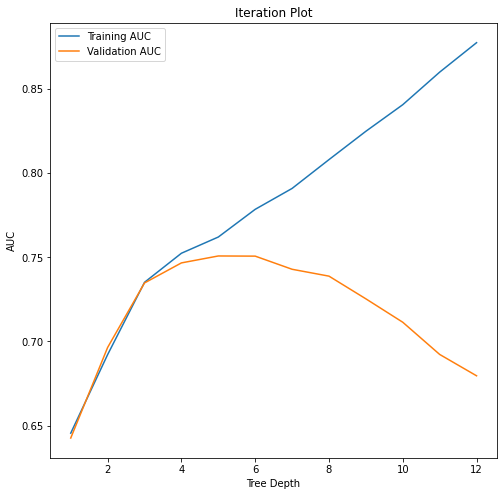

In [30]:
# Plot tree depth vs. training and validation AUC using simple pandas plotting and matplotlib
candidate_results = pd.DataFrame.from_dict(candidate_models, orient='index')
fig, ax = plt.subplots(figsize=(8, 8))
_ = candidate_results[['Training AUC', 'Validation AUC']].plot(title='Iteration Plot',
                                                               ax=ax)
_ = ax.set_xlabel('Tree Depth')
_ = ax.set_ylabel('AUC')